# Проект. Создание рекомендательной системы. Часть 1  

##### Описание задачи
Создание эффективной системы персональных рекомендаций для популярного стримингового сервиса с большим каталогом — более 70 млн треков.  
Для удобства пользователей такая система должна предлагать музыкальные треки для прослушивания на основе их вкусов и предпочтений.  
  
##### Задача машинного обучения  
На основе данных взаимодействий ~1,4 млн пользователей с 1 млн треков необходимо построить пайплайн для расчёта персональных рекомендаций, а также разработать сервис рекомендаций.  
  
##### Результат работы
Набор скриптов в репозитории для расчета персональных рекомендаций и для запуска соответствующего сервиса для их получения.

##### План работы

- Этап 1. Первичная подготовка данных
  - Загрузка файлов с данными, получение общей информации, проверка пропущенных значений, дубликатов
  - Нужно ли изменить тип идентификаторов?
  - Устранение проблем данных треков с неизвестными исполнителями, альбомами, жанрами
  - Выводы по этапу 1
-  Этап 2. Анализ данных и их подготовка
    - Анализ распределения количества прослушанных треков и жанров
    - Поиск наболее популярных треков
    - Поиск наиболее популярных жанров
    - Поиск треков, которые никто не прослушал
    - Сохранение данных в виде датасетов items, events и catalog_names на локальном диске и в S3
    - Выводы по этапу 2
- Этап 3. Офлайн-рекомендации
    - Разбиение данных на тренировочную и тестовую выборки
    - Получение трех видов рекомендаций:
      - top_popular - рекомендация самых популярных треков
      - personal_als - персональные рекомендации
      - similar - рекомендации на основе похожих треков
    - Сохранение рекомендаций в датасетах
    - Построение ранжирующей модели, ранжирование рекомендаций
    - Получение итоговых рекомендаций и их сохранение в датасете
    - Проверка качества рекомендаций с помощью метрик precision@5, recall@5, novelty@5, coverage@5
    - Внутреннее тестирование
    - Сохранение рекомендаций в S3
    - Выводы по этапу 3
- Подведение итогов и общие выводы

In [1]:
import boto3
from botocore.exceptions import ClientError, PartialCredentialsError
from catboost import CatBoostClassifier, Pool
from datetime import time
from dotenv import load_dotenv
import gc
from humanize import naturalsize
from implicit.als import AlternatingLeastSquares
from implicit.cpu.als import AlternatingLeastSquares as ALSClass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import psutil
import random
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
import sys
import textwrap
from threadpoolctl import threadpool_limits
from typing import Optional, List, Tuple

threadpool_limits(1, "blas")
load_dotenv()

RANDOM_STATE = 42
random.seed(RANDOM_STATE)

pd.options.mode.copy_on_write = True

In [2]:
# DataFrame utilities and analysis functions
# 1. xhead
# 2. get_mem_usage
# 3. get_top_tracks
# 4. global_time_split

def xhead(df: pd.DataFrame, title: str = None, top: int = None) -> None:
    """
    Display the top rows of a DataFrame along with some summary information.

    Args:
        df (pandas.DataFrame): The DataFrame to display.
        title (str, optional): An optional title to display before the DataFrame info. Defaults to None.
        top (int, optional): The number of top rows to display. Defaults to 3.

    Returns:
        None
    """
    if top is None:
        top = 3
    if title is not None:
        print(f"{title} info:")
    display(df.head(top))
    print(f"Shape: {df.shape[0]:,.0f} rows × {df.shape[1]} columns")
    print("Unique values: ", end="")
    
    unique_values = [f"{col}: {df[col].nunique()}" for col in df.columns]
    print(*unique_values, sep=', ')


def get_mem_usage(top_k: Optional[int] = None) -> None:
    """
    Print memory usage statistics.

    Args:
        top_k (int, optional): Number of top memory-consuming variables to display.

    Returns:
        None
    """
    if top_k:
        print(f"Топ-{top_k} объемных переменных:")
        for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                                key= lambda x: -x[1])[:top_k]:
            print(f"{name}: {naturalsize(size)}")
        print()

    memory = psutil.virtual_memory()
    print(f"Общая память: {naturalsize(memory.total)}")
    print(f"Доступная память: {naturalsize(memory.available)}")


def get_top_tracks(items: pd.DataFrame, catalog_names: pd.DataFrame, top_k_indices: List[int]) -> pd.DataFrame:
    """
    Get the top tracks from items and catalog names.

    Args:
        items (pd.DataFrame): The DataFrame containing item information.
        catalog_names (pd.DataFrame): The DataFrame containing catalog names with types.
        top_k_indices (List[int]): List of top K item indices.

    Returns:
        pd.DataFrame: DataFrame containing top tracks with artist, album, and genre information.
    """
    return (items
            .query('item_id.isin(@top_k_indices)')
            
            .merge(
                catalog_names[catalog_names['type'] == 'track'], left_on='item_id', right_on='id'
                ).drop(['item_id', 'id', 'type'], axis=1).rename(columns={'name': 'track'})

            .merge(
                catalog_names[catalog_names['type'] == 'album'], left_on='albums', right_on='id'
                ).drop(['albums', 'id', 'type'], axis=1).rename(columns={'name': 'album'})

            .merge(
                catalog_names[catalog_names['type'] == 'artist'], left_on='artists', right_on='id'
                ).drop(['artists', 'id', 'type'], axis=1).rename(columns={'name': 'artist'})

            .merge(
                catalog_names[catalog_names['type'] == 'genre'], left_on='genres', right_on='id'
                ).drop(['genres', 'id', 'type'], axis=1).rename(columns={'name': 'genre'})

            .groupby('track').agg({
                'artist': lambda x: ", ".join(list(x.unique())),
                'album': lambda x: ", ".join(list(x.unique())), 
                'genre': lambda x: ", ".join(list(x.unique()))
                }).reset_index()
            )


def global_time_split(events: pd.DataFrame, str_split_date: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split events DataFrame into training and testing sets based on a split date.

    Args:
        events (pd.DataFrame): The DataFrame containing events.
        str_split_date (str): The date string to split the events DataFrame.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: A tuple containing the training and testing DataFrames.
    """
    global_time_split_idx = events["date"] < pd.to_datetime(str_split_date)

    return events[global_time_split_idx], events[~global_time_split_idx]

In [3]:
# Parquet file and S3 operations
# 1. show_s3_folder
# 2. upload_to_s3
# 3. load
# 4. save

def show_s3_folder(path: str) -> None:
    """
    Display the files in a specified S3 folder.

    Args:
        path (str): The path of the S3 folder to display.

    Returns:
        None
    """
    s3_client = boto3.client('s3', 
                             aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'), 
                             aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
                             endpoint_url=os.getenv('S3_ENDPOINT_URL'))

    response = s3_client.list_objects_v2(Bucket=os.getenv("S3_BUCKET_NAME"))
    
    paginator = s3_client.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=os.getenv("S3_BUCKET_NAME"), Prefix=path)

    print(f"Files in {path} folder:")
    counter = 0
    for page in pages:
        if 'Contents' in page:
            for obj in page['Contents']:
                key = obj['Key']
                if not key.endswith('/'):
                    relative_path = key[len(path):]
                    if '/' not in relative_path:
                        print(key)
                        counter += 1
    if counter == 0:
        print("No files found.")
    else:
        print(f"{counter} file(s) found.")


def upload_to_s3(file_name: str, object_name: str = None) -> bool:
    """
    Upload a file to an S3 bucket.

    Args:
        file_name (str): File to upload.
        object_name (str, optional): S3 object name. If not specified, file_name is used.

    Returns:
        bool: True if file was uploaded, False otherwise.
    """
    if object_name is None:
        object_name = os.path.basename(file_name)
    
    s3_client = boto3.client('s3', 
                             aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'), 
                             aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
                             endpoint_url=os.getenv('S3_ENDPOINT_URL'))
    try:
        s3_client.upload_file(file_name, os.getenv("S3_BUCKET_NAME"), object_name)
        print(f"File {file_name} uploaded to {object_name}")
        return True
    except PartialCredentialsError:
        print("Incomplete credentials provided.")
    except ClientError as e:
        formatted_error = textwrap.fill(str(e), width=70)
        print(f"Upload failed:\nDetails: {formatted_error}")
    except Exception as e:
        formatted_error = textwrap.fill(str(e), width=70)
        print(f"General Error: An unexpected error occurred: {formatted_error}")
    return False


def load(file_name: str, filters: Optional[dict] = None) -> pd.DataFrame:
    """
    Load a Parquet file into a DataFrame.

    Args:
        file_name (str): Name of the file to load (without extension).
        filters (dict, optional): Filters to apply when loading the Parquet file.

    Returns:
        pd.DataFrame: The loaded DataFrame.
    """
    return pd.read_parquet("parquet/" + file_name + ".parquet", filters=filters)


def save(file: pd.DataFrame, file_name: str) -> None:
    """
    Save a DataFrame to a Parquet file.

    Args:
        file (pd.DataFrame): DataFrame to save.
        file_name (str): Name of the file to save (without extension).

    Returns:
        None
    """
    file.to_parquet("parquet/" + file_name + ".parquet")

In [4]:
# List of functions for calculating metrics
# 1. process_events_recs_for_binary_metrics
# 2. compute_cls_metrics
# 3. compute_bam_metrics
# 4. get_metrics_for_rec_type

def process_events_recs_for_binary_metrics(
    events_train: pd.DataFrame, 
    events_test: pd.DataFrame, 
    recs: pd.DataFrame, 
    top_k: Optional[int] = None
) -> pd.DataFrame:
    """
    Annotate <user_id, item_id> pairs for the common set of users with the following features:
    - gt (ground truth)
    - pr (prediction)
    top_k: calculations are performed only for the top k recommendations.

    Args:
        events_train (pd.DataFrame): Training events DataFrame.
        events_test (pd.DataFrame): Testing events DataFrame.
        recs (pd.DataFrame): Recommendations DataFrame.
        top_k (Optional[int]): Number of top recommendations to consider.

    Returns:
        pd.DataFrame: DataFrame containing annotated <user_id, item_id> pairs with binary metrics.
    """
    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # Model can recommend only items from events_train
    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(events_train["item_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], how="outer"
    )    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common


def compute_cls_metrics(events_recs_for_binary_metric: pd.DataFrame) -> Tuple[float, float]:
    """
    Compute "classification" precision and recall metrics for annotated recommendations.

    Args:
        events_recs_for_binary_metric (pd.DataFrame): DataFrame containing event recommendations with 
                                                      columns 'user_id', 'tp', 'fp', and 'fn'.
    
    Returns:
        Tuple[float, float]: A tuple containing the precision and recall metrics.
    """
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum() / (groupper["tp"].sum() + groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall


def compute_bam_metrics(events_recs_for_binary_metrics: pd.DataFrame) -> Tuple[float, float]:
    """
    Compute "beyond-accuracy" novelty and coverage metrics for annotated recommendations.

    Args:
        events_recs_for_binary_metrics (pd.DataFrame): DataFrame containing event recommendations
                                                            with binary metrics and columns 'pr' and 'item_id'.
    
    Returns:
        Tuple[float, float]: A tuple containing the novelty and coverage metrics.
    """
    
    # novelty = (1 / N) * sum(1/p1 + 1/p2 + ...), where pi - popularity (number of unique users)
    novelty = (events_recs_for_binary_metrics.query('pr == True')
               .groupby('item_id')['user_id'].agg(lambda x: 1/len(set(x))).mean())
    
    # coverage = number_of_predictions / number_of_items
    number_of_unique_recs = events_recs_for_binary_metrics.query('pr == True')['item_id'].nunique()
    total_number_of_unique_items = events_recs_for_binary_metrics['item_id'].nunique()
    coverage = number_of_unique_recs / total_number_of_unique_items
    
    return novelty, coverage


def get_metrics_for_rec_type(
    rec_score_name: str, 
    events_inference: pd.DataFrame, 
    events_test_2: pd.DataFrame, 
    recommendations: pd.DataFrame, 
    top_k: Optional[int] = None
) -> List:
    """
    Compute precision, recall, novelty, and coverage metrics for a specific recommendation type.

    Args:
        rec_score_name (str): The name of the recommendation score column.
        events_inference (pd.DataFrame): DataFrame containing inference events.
        events_test_2 (pd.DataFrame): DataFrame containing test events.
        recommendations (pd.DataFrame): DataFrame containing recommendations.
        top_k (Optional[int]): Number of top recommendations to consider.

    Returns:
        List: A list containing the recommendation score name, precision, recall, novelty, and coverage metrics.
    """
    
    events_recs_for_binary_metrics = process_events_recs_for_binary_metrics(
        events_inference,
        events_test_2,
        recommendations.rename(columns={rec_score_name: "score"}), 
        top_k=top_k)
    
    precision, recall = compute_cls_metrics(events_recs_for_binary_metrics)
    novelty, coverage = compute_bam_metrics(events_recs_for_binary_metrics)

    return [rec_score_name, precision, recall, novelty, coverage]

#### Этап 1. Первичная подготовка данных
  

##### Загрузка файлов с данными, получение общей информации, проверка пропущенных значений, дубликатов

In [5]:
get_mem_usage()

Общая память: 33.7 GB
Доступная память: 31.4 GB


In [7]:
tracks = pd.read_parquet("parquet/tracks.parquet")
tracks.info()
temp_tracks = tracks.copy()

# convert to hashable type
for col in ['albums', 'artists', 'genres']:
    temp_tracks[col] = temp_tracks[col].apply(tuple)

print(f"\nПропусков: {tracks.isna().sum().sum()}, дубликатов: {temp_tracks[temp_tracks.duplicated(keep=False)].sum().sum()}")
display(tracks.head())

del temp_tracks

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB

Пропусков: 0, дубликатов: 0


,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


Датасет с музыкальными треками представляет собой датафрейм со значениями в виде списков. Пропусков и дубликатов нет.

In [8]:
catalog_names = pd.read_parquet("parquet/catalog_names.parquet")

catalog_names.info()
print(f"\nПропусков: {tracks.isna().sum().sum()}, дубликатов: {catalog_names.duplicated().sum()}")
display(catalog_names.sample(5, random_state=RANDOM_STATE))

<class 'pandas.core.frame.DataFrame'>
Index: 1812501 entries, 0 to 1812500
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 55.3+ MB

Пропусков: 0, дубликатов: 0


,id,type,name
1754387,83304048,track,Для неё
1758766,84423662,track,Нонсенс
444263,9062473,album,Best Of
330070,5574795,album,Koss City
43476,169316,album,This Is... 1979


In [9]:
upload_to_s3("parquet/catalog_names.parquet", "recsys/data/catalog_names.parquet")

File parquet/catalog_names.parquet uploaded to recsys/data/catalog_names.parquet


True

Датасет с каталогом хранит названия объектов 4 типов - треков, альбомов, исполнителей, жанров. Пропусков и дубликатов нет.

In [8]:
# < 2 min
interactions = pd.read_parquet("parquet/interactions.parquet")

interactions.info()
print(f"\nПропусков: {interactions.isna().sum().sum()}, дубликатов: {interactions.duplicated().sum()}")
display(interactions.sample(5, random_state=RANDOM_STATE))

get_mem_usage()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB

Пропусков: 0, дубликатов: 0


,user_id,track_id,track_seq,started_at
130,844258,3581309,131,2022-06-05
433,1091434,14937363,434,2022-06-29
526,73981,48591660,527,2022-09-26
9,78605,732405,10,2022-09-14
1202,1273064,40339506,1203,2022-08-24


Общая память: 33.7 GB
Доступная память: 25.2 GB


Датасет взаимодействий "пользователь-трек" большой, нужно следить за использованием памяти и избегать хранения лишних временных переменных. Пропусков и дубликатов нет. Индексы не уникальны. Столбец даты хранит только год-месяц-число, часы и минуты отсутствуют.

##### Нужно ли изменить тип идентификаторов?
В данных есть идентификаторы двух типов - номера (индексы) элементов и идентификаторы типов элементов в каталоге.  
Для хранения номеров элементов в tracks и intercations с диапазонами значений от 0 до ~10^9 достаточно int32. 
Идентификаторы типов в каталоге являются именно типами, а не признаками, поэтому изменения не требуют.  
Для экономии места можно было бы в catalog_names тип id поменять на int32, а тип на uint8, но этот датасет небольшой, много сэкономить не получится, а обозначения типов как int снижает наглядность кода в запросах.  
Поэтому изменение типа идентификаторов обоих типов не требуется.

##### Устранение проблем данных треков с неизвестными исполнителями, альбомами, жанрами
Выведем общую информацию о данных, в том числе о неизвестных элементах.

In [9]:
print(f"Типы идентификаторов: {', '.join(catalog_names.type.unique())}\n")
print(f"Уникальных альбомов: {catalog_names[catalog_names['type']=='album']['id'].nunique():,.0f}")
print(f"Уникальных исполнителей: {catalog_names[catalog_names['type']=='artist']['id'].nunique():,.0f}")
print(f"Уникальных жанров: {catalog_names[catalog_names['type']=='genre']['id'].nunique()}")
print(f"Уникальных пользователей: {interactions['user_id'].nunique():,.0f}")
print(f"Уникальных взаимодействий: {len(interactions):,.0f}\n")
print(f"Треков без названий альбомов: {len(tracks[tracks.albums.apply(len) == 0])}")
print(f"Треков без названий исполнителей: {len(tracks[tracks.artists.apply(len) == 0])}")
print(f"Треков без названий жанров: {len(tracks[tracks.genres.apply(len) == 0])}\n")
print(f"Первое событие: {interactions.started_at.min().strftime('%H:%M:%S, %d %B %Y')}")
print(f"Последнее событие : {interactions.started_at.max().strftime('%H:%M:%S, %d %B %Y')}\n")
print(f"Пар пользователь-трек с количеством взаимодействий более 1: {(interactions.groupby(['user_id', 'track_id'])['started_at'].count() > 1).sum()}")

tracks_genres = np.array(sorted([x for x in tracks.explode('genres').genres.unique() if not np.isnan(x)]))
catalog_genres = catalog_names[catalog_names.type == 'genre']['id'].unique()

print(f"Количество жанров треков, которых нет в каталоге: {len(set(tracks_genres) - set(catalog_genres))}")

Типы идентификаторов: album, artist, genre, track

Уникальных альбомов: 658,724
Уникальных исполнителей: 153,581
Уникальных жанров: 166
Уникальных пользователей: 1,373,221
Уникальных взаимодействий: 222,629,898

Треков без названий альбомов: 18
Треков без названий исполнителей: 15369
Треков без названий жанров: 3687

Первое событие: 00:00:00, 01 January 2022
Последнее событие : 00:00:00, 31 December 2022

Пар пользователь-трек с количеством взаимодействий более 1: 0
Количество жанров треков, которых нет в каталоге: 30


Есть треки без названий, количество их небольшое, эту информацию можно удалить. Названия жанров сами по себе могут быть любыми, поэтому дадим жанрам, которых нет в каталоге, автоматические имена.  
Отметим, что все взаимодействия пользователей с треками уникальны, т.е. у нас нет данных не только о том, нравится трек пользователю или нет, но и о том, сколько раз он его прослушал и когда перестал слушать.  
Дадим названия для жанров, отсутствующих в каталоге:

In [10]:
for tr in set(tracks_genres) - set(catalog_genres):
    catalog_names.loc[len(catalog_names)] = [tr, 'genre', 'genre_' + str(tr)]

display(catalog_names.tail())

catalog_genres = catalog_names[catalog_names.type == 'genre']['id'].unique()
print(f"Количество жанров треков, которых нет в каталоге: {len(set(tracks_genres) - set(catalog_genres))}")

,id,type,name
1812496,167,genre,genre_167
1812497,168,genre,genre_168
1812498,169,genre,genre_169
1812499,124,genre,genre_124
1812500,126,genre,genre_126


Количество жанров треков, которых нет в каталоге: 0


Таким образом, после удаления строк с отсутствующей информацией, треков с неизвестными названиями у нас не останется.  
Датасет с треками требует "развертывания", т.е. раскрытия списков по строкам, поэтому удаление данных сделаем позже.

##### Выводы по этапу 1
- Датасеты загружены успешно, пропусков и дубликатов нет
- Устранены пробелы в названиях жанров, отмечены треки для удаления
- Датасет взаимодействий большой, необходимо использовать решения, разумные с точки зрения памяти и времени вычислений

#### Этап 2. Анализ данных и их подготовка
##### Анализ распределения количества прослушанных треков и жанров
Отметим еще раз наиболее важное обстоятельство - у нас есть данные о начале прослушивания трека пользователем, а не о количестве и не его оценке трека или жанра. Поэтому все последующие выводы о популярности, количестве прослушиваний основаны на том упрощении, что если пользователь начал слушать трек, то он прослушал его ровно один раз, и это является положительной оценкой.

Получим данные по количеству взаимодействий с треками, выведем топ активных пользователей, затем построим распределение количества треков по пользователям.

In [11]:
listen_counts = interactions.groupby('user_id')['track_id'].count().reset_index().rename(columns={'track_id': 'num_tracks'})

print('Топ-5 пользователей')
listen_counts.sort_values(by='num_tracks', ascending=False)[:5].reset_index(drop=True)

Топ-5 пользователей


,user_id,num_tracks
0,398979,16637
1,1200889,15392
2,590868,15136
3,731216,13223
4,339714,12768


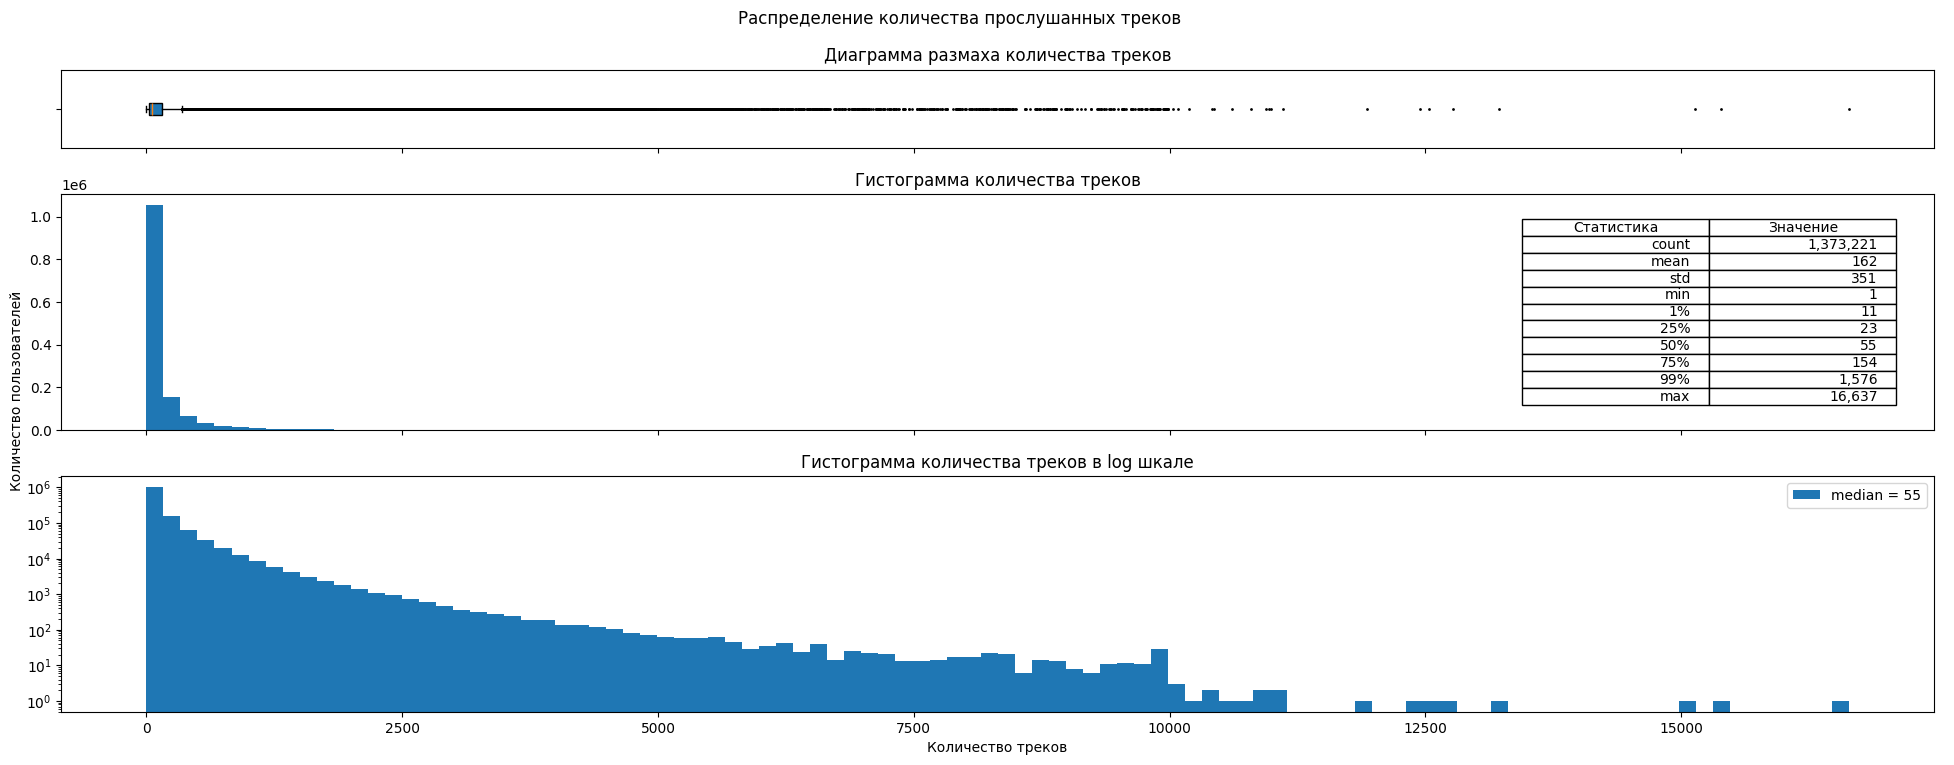

In [12]:
fig, ax = plt.subplots(nrows = 3,ncols= 1, sharex=True, figsize=(20, 8), gridspec_kw={'height_ratios': [1, 3, 3]})
plt.suptitle('Распределение количества прослушанных треков')

plt.subplot(311)
plt.title('Диаграмма размаха количества треков')
plt.boxplot(listen_counts['num_tracks'], vert=False,  patch_artist=True, tick_labels=[''], flierprops={'marker': '.', 'markersize': 2})

plt.subplot(312)
plt.title('Гистограмма количества треков')
plt.hist(listen_counts['num_tracks'], bins=100)
plt.table(
    cellText=[[x, f"{y:,.0f}"] for x, y in listen_counts['num_tracks'].describe(percentiles=[.01, .25, .5, .75, .99]).to_dict().items()], 
    colLabels=["Статистика", "Значение"], 
    colWidths = [0.1,0.1], loc='center right'
)

plt.subplot(313)
plt.title('Гистограмма количества треков в log шкале')
plt.hist(listen_counts['num_tracks'], bins=100, log=True, label=f"median = {int(listen_counts.num_tracks.median())}")
plt.legend()

fig.add_subplot(1, 1, 1, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel('Количество треков')
plt.ylabel('Количество пользователей')
plt.tight_layout()
plt.show()

Распределение сильно скошено вправо, основная масса пользователей начало слушать за год от 1 до нескольких сотен треков (медиана = 55), то есть в среднем пользователи выбирали меньше одного нового трека в день. Можно посчитать, что пользователи с количеством новых треков более ~ 350 являются выбросами.  
Чуть более детальное представление дает логарифмическая гистограмма.

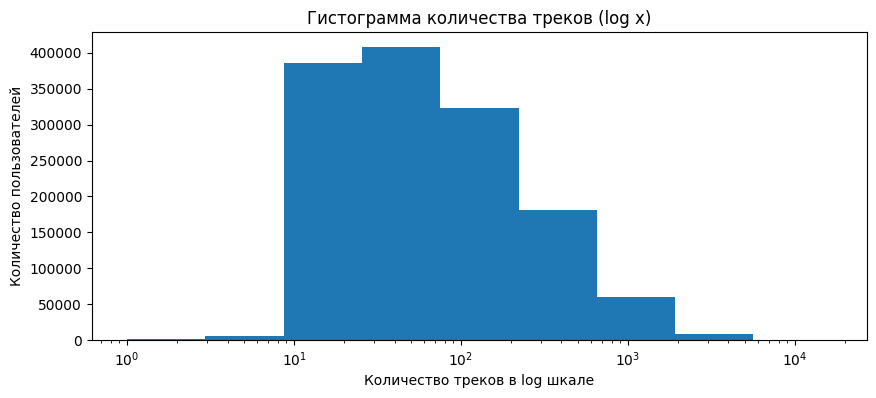

In [13]:
plt.figure(figsize=(10, 4))
plt.title('Гистограмма количества треков (log x)')
plt.xlabel('Количество треков в log шкале')
plt.ylabel('Количество пользователей')

start, stop = np.log10(min(listen_counts['num_tracks'])), np.log10(max(listen_counts['num_tracks']))
bins = 10 ** np.linspace(start, stop, 10)
plt.hist(listen_counts['num_tracks'], bins=bins, log=False)

plt.xscale('log')
plt.show()

По меткам даты можно посмотреть взаимодействия в течение года (по неделям).

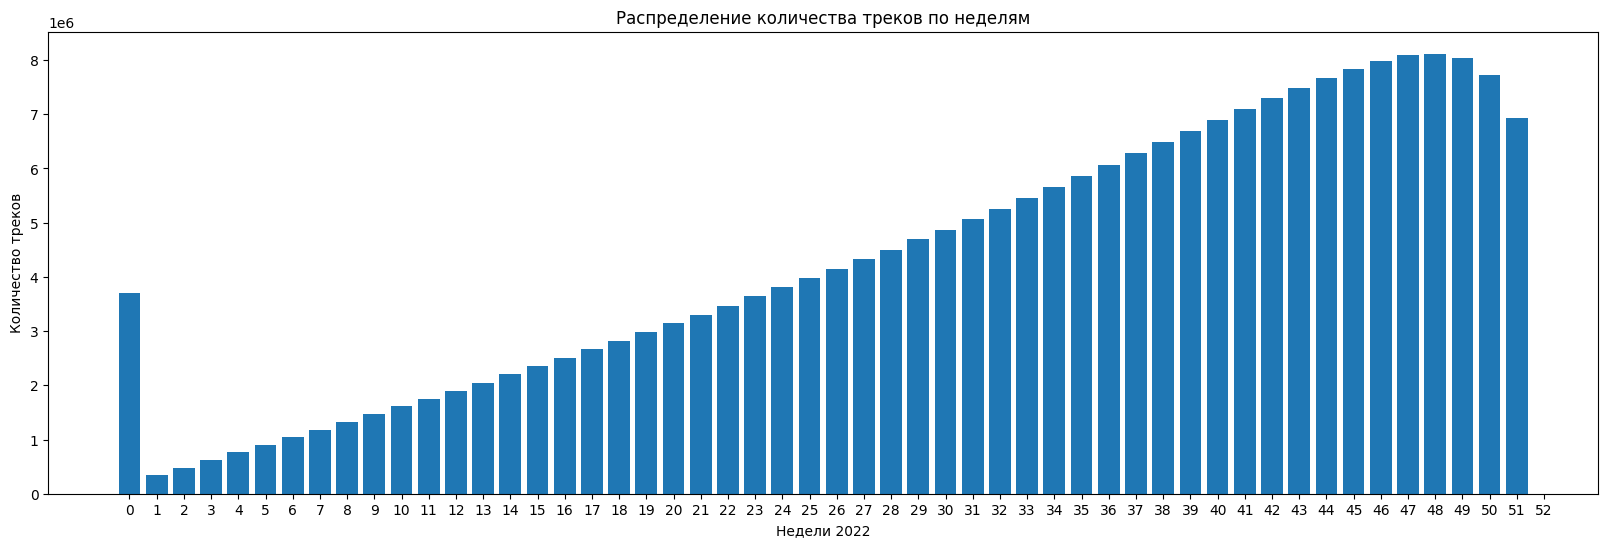

In [14]:
# < 2 min
interactions_by_weeks = interactions.groupby(pd.Grouper(key='started_at', freq='W')).size().reset_index(name='num_tracks')

plt.figure(figsize=(20, 6))
week_list = interactions_by_weeks['started_at'].dt.strftime('%W').astype(int)
#plt.bar(interactions_by_weeks['started_at'].dt.strftime('%W').astype(int), interactions_by_weeks['num_tracks'])
plt.bar(week_list, interactions_by_weeks['num_tracks'])
plt.xlabel('Недели 2022')
plt.ylabel('Количество треков')
plt.title('Распределение количества треков по неделям')
plt.xticks(np.arange(len(week_list)))
plt.show()

Количество взаимодействий в течение года увеличивается, датасет не дает объяснения причины такой тенденции.  
Можно предположить, что это связано с развитием сервиса, а именно, появлением новых клиентов и увеличением общей активности.  
  
Немного сократим датасет interactions, удалив столбец с нумерацией треков для пользователя (при желании, его можно получить с точностью до порядка взаимодействий в одном дне) и изменим имя столбца даты на более лаконичное.  
  
Заодно и создадим уникальные индексы.

In [15]:
interactions.drop('track_seq', axis=1, inplace=True)
interactions.rename(columns={'started_at': 'date'}, inplace=True)
interactions.reset_index(drop=True, inplace=True)
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222629898 entries, 0 to 222629897
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   user_id   int32         
 1   track_id  int32         
 2   date      datetime64[ns]
dtypes: datetime64[ns](1), int32(2)
memory usage: 3.3 GB


##### Поиск наболее популярных треков
Сначала сделаем большое преобразование - раскроем списки в данных о треках в строки датасета.

In [16]:
tracks_original = tracks.copy()

for col in ['albums', 'artists', 'genres']:
    tracks = tracks.explode(col)

tracks = tracks.reset_index(drop=True)

Теперь извлечем данные для каждого трека из каталога.

In [17]:
# < 2 min
genres = catalog_names[catalog_names['type'] == 'genre'].drop('type', axis=1).reset_index(drop=True)
artists = catalog_names[catalog_names['type'] == 'artist'].drop('type', axis=1).reset_index(drop=True)
tracks_names = catalog_names[catalog_names['type'] == 'track'].drop('type', axis=1).reset_index(drop=True)

track_data = (tracks
    .merge(tracks_names, left_on='track_id', right_on='id')
    .merge(artists, left_on='artists', right_on='id')
    .merge(genres, left_on='genres', right_on='id')
    .drop(['albums', 'artists', 'genres', 'id_x', 'id_y', 'id'], axis=1)
    .rename(columns={'name_x': 'name', 'name_y': 'artist', 'name': 'genre'})
    .drop_duplicates()
    .reset_index(drop=True)
    )

track_grouped_data = (tracks
    .merge(track_data)
    .groupby(['track_id', 'name']).agg({'artist': lambda x: list(x.unique()), 'genre': lambda x: list(x.unique())})
    .reset_index())

track_grouped_data.head()

,track_id,name,artist,genre
0,26,Complimentary Me,[Elizabeth & the Catapult],"[pop, folk]"
1,38,Momma's Boy,[Elizabeth & the Catapult],"[pop, folk]"
2,135,Atticus,[Noisettes],[pop]
3,136,24 Hours,[Noisettes],[pop]
4,138,Don't Upset The Rhythm (Go Baby Go),[Noisettes],[pop]


In [18]:
k = 10

track_listens = (
    interactions
    .groupby('track_id')['user_id'].count()
    .to_frame()
    .rename(columns={'user_id': 'num_listens'}).reset_index()
)

top_tracks = (
    track_listens
    .sort_values(by='num_listens', ascending=False)[:k]
    .merge(track_grouped_data)
    .rename(columns={'user_id': 'total_listens'})
)

print(f"Top-{k} tracks")
display(get_top_tracks(tracks.rename(columns={'track_id': 'item_id'}), catalog_names, top_tracks['track_id'].tolist()))

Top-10 tracks


,track,artist,album,genre
0,Believer,Imagine Dragons,"Shape Of Pop, NOW That's What I Call Music, Ev...","rock, allrock"
1,I Got Love,"Miyagi & Эндшпиль, Рем Дигга",I Got Love,"rusrap, rap"
2,In The End,"Tommee Profitt, Fleurie, Mellen Gi","Tik Tock HITS 2021 Viral Italia, In the End, ...",rnb
3,Life,Zivert,"Life, Made in Russia, Fresh Dance, Учителя (Му...","pop, ruspop"
4,Numb,Linkin Park,"Meteora, 00s Rock Anthems","numetal, metal"
5,Shape Of My Heart,Sting,"Ten Summoner's Tales, 25 Years, The Best Of 25...","rock, allrock, pop"
6,Shape of You,Ed Sheeran,"Shape of You, ÷, Summer Vibes, Pop",pop
7,Smells Like Teen Spirit,Nirvana,"Nevermind, Nirvana, Skiing Music, Smells Like ...","alternative, rock, allrock"
8,Way Down We Go,KALEO,"Way down We Go, Summer Music 2016, A/B, DFM Da...",indie
9,Юность,Dabro,Юность,"pop, ruspop"


##### Поиск наиболее популярных жанров
Слияние данных и взаимодействиях занимает много памяти, поэтому используем быструю операцию hstack() для объединения списков и обернем это функцией, чтобы не создавать лишние копии результатов слияния.

In [19]:
# < 5 min
def get_user_genres_count(interactions, tracks):
    return (
        interactions[['user_id', 'track_id']]
        .merge(tracks[['track_id', 'genres']])
        .groupby('user_id')['genres']
        .apply(lambda x: len(set(np.hstack(x))))
        .reset_index()
    )

user_genres_count = get_user_genres_count(interactions, tracks_original)

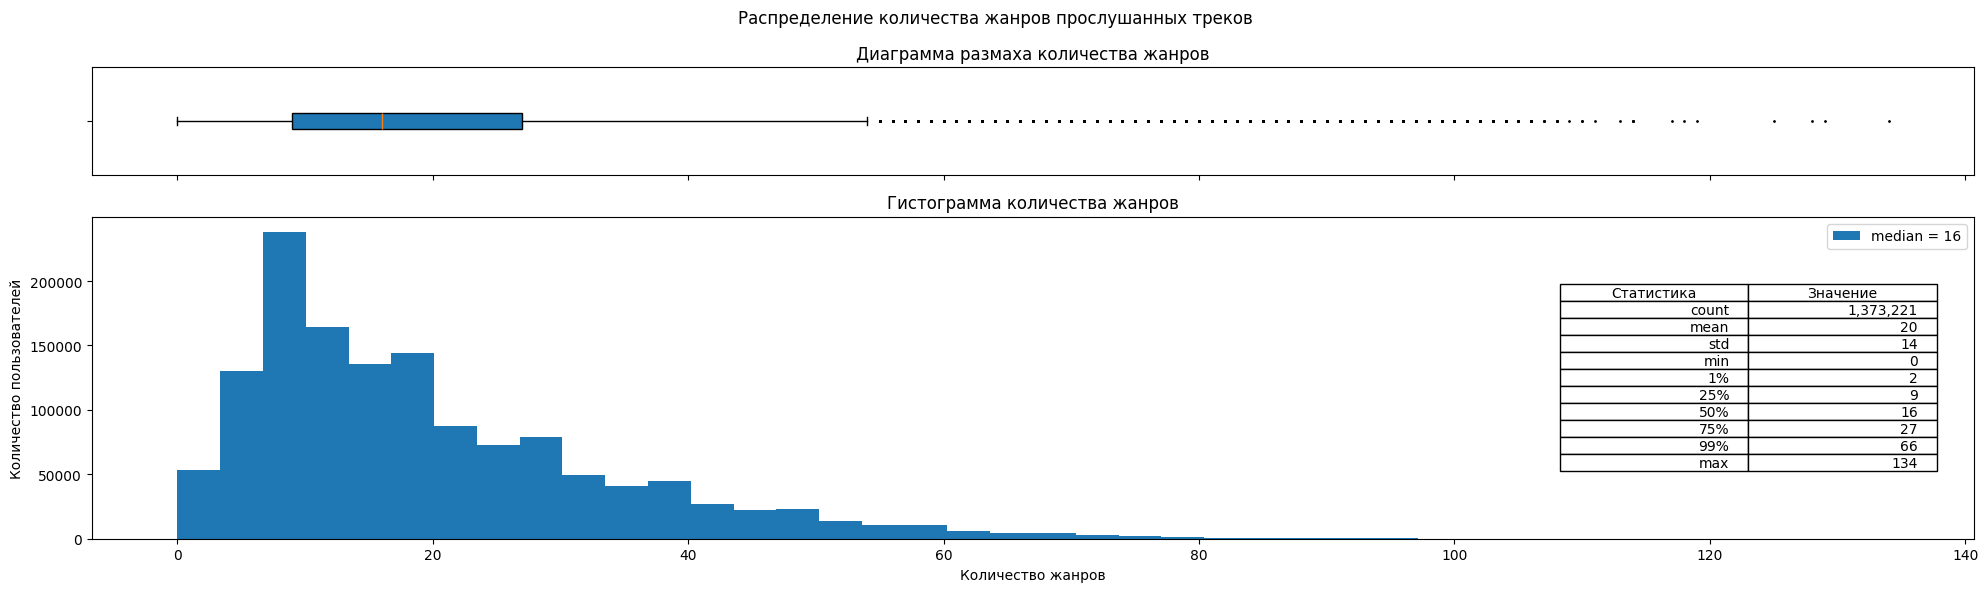

In [20]:
fig, ax = plt.subplots(nrows = 2,ncols= 1, sharex=True, figsize=(20, 6), gridspec_kw={'height_ratios': [1, 3]})

plt.suptitle('Распределение количества жанров прослушанных треков')
plt.subplot(211)
plt.title('Диаграмма размаха количества жанров')
plt.boxplot(
    user_genres_count['genres'], 
    vert=False,  
    patch_artist=True, 
    tick_labels=[''], 
    flierprops={'marker': '.', 'markersize': 2}
)

plt.subplot(212)
plt.title('Гистограмма количества жанров')
plt.hist(
    user_genres_count['genres'], 
    bins=40, 
    label=f"median = {int(user_genres_count.genres.median())}"
)

plt.table(
    cellText=[
        [x, f"{y:,.0f}"] for x, y in user_genres_count['genres']
        .describe(percentiles=[.01, .25, .5, .75, .99])
        .to_dict().items()
    ], 
    colLabels=["Статистика", "Значение"], 
    colWidths = [0.1,0.1], 
    loc='center right')

plt.xlabel('Количество жанров')
plt.ylabel('Количество пользователей')
plt.legend()

plt.tight_layout()
plt.show()

Распределение жанров больше похоже на нормальное, пользователи в среднем предпочитают небольшое количество жанров (медиана 16 из 166).  
Самыми популярными являются, очевидно, наиболее общие категории.

In [21]:
k = 10
top_genres = (
    track_listens
    .sort_values(by='num_listens', ascending=False)
    .merge(track_data).groupby('genre')['num_listens'].sum().to_frame()
    .sort_values(by='num_listens', ascending=False)[:k]
    .reset_index()
)

print(f"Топ-{k} популярных жанров")
display(top_genres.style.format({'num_listens': '{:,.0f}'}))

Топ-10 популярных жанров


,genre,num_listens
0,pop,"68,348,053"
1,rap,"53,847,977"
2,rusrap,"34,133,118"
3,allrock,"33,628,489"
4,ruspop,"31,831,506"
5,electronics,"29,622,279"
6,dance,"27,848,368"
7,foreignrap,"19,303,267"
8,rock,"14,243,655"
9,rusrock,"13,973,571"


##### Поиск треков, которые никто не прослушал

In [22]:
unique_tracks = set(tracks.track_id)
listened_tracks = set(interactions.track_id)
catalog_tracks = set(catalog_names[catalog_names.type == 'track']['id'])

print(
    f"Отличий между уникальными треками ({len(unique_tracks):,.0f}) "
    f"и треками в каталоге ({len(catalog_tracks):,.0f}): "
    f"{len(unique_tracks ^ catalog_tracks)}"
)

print(
    f"Отличий между уникальными треками ({len(unique_tracks):,.0f}) "
    f"и прослушанными треками ({len(listened_tracks):,.0f}): "
    f"{len(unique_tracks ^ listened_tracks)}"
)

Отличий между уникальными треками (1,000,000) и треками в каталоге (1,000,000): 0
Отличий между уникальными треками (1,000,000) и прослушанными треками (1,000,000): 0


Как видим, все треки, которые есть во взаимодействиях, присутствуют в датасете треков и каталоге, то есть каждый трек из 1,000,000 был прослушан. Хотя у некоторых треков, как было выяснено, есть пропущенные названия альбомов, жанров, исполнителей.  

##### Сохранение данных в виде датасетов items, events и catalog_names на локальном диске и в S3
Удалим треки с неполной информацией.

In [23]:
tracks_to_drop = tracks[tracks.isna().any(axis=1)]['track_id'].unique()
print("tracks:")
print(f"Записей к удалению: {len(tracks_to_drop)}")

tracks = tracks.dropna().reset_index(drop=True)
print(f"Удалено {100 - tracks.track_id.nunique() / 1_000_000 * 100:.2f} % записей")

tracks:
Записей к удалению: 19023
Удалено 1.90 % записей


Чтобы не создавать копии большого датасета, исключим ненужные треки из interactions при сохранении, а пока оценим потери данных.

In [24]:
len_interactions = len(interactions)

interactions_to_drop = interactions['track_id'].isin(tracks_to_drop)

print("interactions:")
print(f"Записей к удалению: {interactions_to_drop.sum():,.0f}")
print(f"Будет удалено {interactions_to_drop.sum() / len_interactions * 100:.2f} % записей")

interactions:
Записей к удалению: 445,449
Будет удалено 0.20 % записей


Потери минимальны.  
Переименуем столбцы 'track_id' в 'item_id' для общности названий.  
Сохраним датасеты локально и удаленно.

In [25]:
tracks.rename(columns={'track_id': 'item_id'}).to_parquet("parquet/items.parquet")
interactions[~interactions_to_drop] \
    .rename(columns={'track_id': 'item_id'}) \
    .to_parquet("parquet/events.parquet")
catalog_names.to_parquet("parquet/catalog_names.parquet")

upload_to_s3("parquet/items.parquet", "recsys/data/items.parquet")
upload_to_s3("parquet/events.parquet", "recsys/data/events.parquet")
print()
show_s3_folder("recsys/data/")

File parquet/items.parquet uploaded to recsys/data/items.parquet
File parquet/events.parquet uploaded to recsys/data/events.parquet

Files in recsys/data/ folder:
recsys/data/events.parquet
recsys/data/items.parquet
2 file(s) found.


In [6]:
upload_to_s3("parquet/items.parquet", "recsys/data/items.parquet")
upload_to_s3("parquet/events.parquet", "recsys/data/events.parquet")
print()
show_s3_folder("recsys/data/")

File parquet/items.parquet uploaded to recsys/data/items.parquet
File parquet/events.parquet uploaded to recsys/data/events.parquet

Files in recsys/data/ folder:
recsys/data/events.parquet
recsys/data/items.parquet
2 file(s) found.


Отследим изменения в свободной памяти.

In [26]:
del interactions, tracks, track_data, tracks_original, catalog_names, track_grouped_data, interactions_to_drop, tracks_names
gc.collect()
get_mem_usage(10)

Топ-10 объемных переменных:
unique_tracks: 33.6 MB
listened_tracks: 33.6 MB
catalog_tracks: 33.6 MB
listen_counts: 16.5 MB
user_genres_count: 16.5 MB
artists: 13.2 MB
track_listens: 12.0 MB
tracks_to_drop: 152.3 kB
genres: 14.5 kB
_i2: 11.9 kB

Общая память: 33.7 GB
Доступная память: 26.9 GB


"Наших" объемных переменных нет, но среда выполнения может создавать свои.

#####  Выводы по этапу 2
- Получены распределения количества прослушанных треков и жанров по количеству пользователей
- Получены данные о популярных треках и жанрах
- Треков, которые никто не прослушал, не обнаружено
- Успешно сохранены все данные, локально и удаленно

#### Этап 3. Офлайн-рекомендации
##### Разбиение данных на тренировочную и тестовую выборки
Реализуем концепцию ансамблирования с двухстадийным подходом.  
На первой стадии соберем рекомендации от базовых алгоритмов, на второй - будем ранжировать эти рекомендации и генерировать итоговые.

In [27]:
items = load("items")
catalog_names = load("catalog_names")
events_train, events_test = global_time_split(load("events"), "2022-12-16")

get_mem_usage()

Общая память: 33.7 GB
Доступная память: 20.8 GB


##### Получение трех видов рекомендаций:
- top_popular - рекомендация самых популярных треков
- personal_als - персональные рекомендации
- similar - рекомендации на основе похожих треков

Вычислим рекомендации top_popular - самые популярные треки, как треки из датасета взаимодействий с максимальным числом уникальных пользователей.

In [28]:
def top_popular_generate():
    tracks_popularity = (
        events_train
        .groupby(["item_id"])
        .agg(users=("user_id", "nunique"))
        .sort_values(by='users', ascending=False)
        .reset_index()
    )

    print('Топ-5 популярных треков')
    display(
        get_top_tracks(
            items, catalog_names, 
            list(tracks_popularity.head().item_id)
        )
    )

    k = 100
    save(tracks_popularity[:k], "top_popular")


top_popular_generate()

Топ-5 популярных треков


,track,artist,album,genre
0,Believer,Imagine Dragons,"Shape Of Pop, NOW That's What I Call Music, Ev...","rock, allrock"
1,I Got Love,"Miyagi & Эндшпиль, Рем Дигга",I Got Love,"rusrap, rap"
2,Numb,Linkin Park,"Meteora, 00s Rock Anthems","numetal, metal"
3,Smells Like Teen Spirit,Nirvana,"Nevermind, Nirvana, Skiing Music, Smells Like ...","alternative, rock, allrock"
4,Way Down We Go,KALEO,"Way down We Go, Summer Music 2016, A/B, DFM Da...",indie


Персональные рекомендации personal_als получим с помощью алгоритма AlternatingLeastSquares библиотеки implicit.  
Для этого нужно последовательно проиндексировать данные и генерировать разреженную матрицу.

In [29]:
# < 10 min
user_encoder = LabelEncoder()
user_encoder.fit(load("events")["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

item_encoder = LabelEncoder()
item_encoder.fit(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

user_item_matrix_train = csr_matrix(
    (
        np.ones(len(events_train), dtype=np.int8),
        (events_train['user_id_enc'], events_train['item_id_enc'])
    ),
    dtype=np.int8
)

als_model = AlternatingLeastSquares(
    factors=20, iterations=10, regularization=0.01, random_state=RANDOM_STATE
)

als_model.fit(user_item_matrix_train)

  0%|          | 0/10 [00:00<?, ?it/s]

Данные о взаимодействиях пока не нужны, сохраним их и освободим память.

In [30]:
events_train.drop(['user_id_enc', 'item_id_enc'], axis=1, inplace=True)
events_test.drop(['user_id_enc', 'item_id_enc'], axis=1, inplace=True)

save(events_train, "events_train")
save(events_test, "events_test")

del events_train, events_test

get_mem_usage()

Общая память: 33.7 GB
Доступная память: 28.4 GB


Сгенерируем по 20 рекомендаций для каждого пользователя с помощью метода recommend(), исключив треки, с которыми было взаимодействие.  
Промежуточные результаты сохраним и загрузим методами numpy.  
Преобразуем полученные рекомендации в DataFrame и сохраним их в parquet.  
Выведем пример рекомендаций для случайного пользователя.

In [31]:
%%time
# < 35 min

user_ids_encoded = range(len(user_encoder.classes_))

als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=True,
    N=20
)

np.savez(
    'als_recommendations.npz', 
    item_ids_enc=als_recommendations[0], 
    als_scores=als_recommendations[1]
)
als_recommendations = np.load('als_recommendations.npz')

als_recommendations = pd.DataFrame(
    {
        "user_id_enc": user_ids_encoded,
        "item_id_enc": als_recommendations['item_ids_enc'].tolist(), 
        "score": als_recommendations['als_scores'].tolist()
    }
)

als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

test_user = random.choice(als_recommendations.user_id.unique())
k_user = 5

print(f"Топ-{k_user} персональных рекомендаций для пользователя {test_user}")
display(get_top_tracks(items, catalog_names, list(als_recommendations.query('user_id == @test_user').item_id)[:k_user]))

save(als_recommendations.rename(columns={'score': 'als_score'})[['user_id', 'item_id', 'als_score']], "personal_als")

del als_recommendations

Топ-5 персональных рекомендаций для пользователя 1342756


,track,artist,album,genre
0,In The End,"Tommee Profitt, Fleurie, Mellen Gi","In the End, Christian TikTok, Trending Now 202...",rnb
1,Intro,The xx,xx,indie
2,Opr,Gesaffelstein,Conspiracy Pt.2,"electronics, techno"
3,Paris,Else,Paris,electronics
4,Quick Musical Doodles,Two Feet,First Steps,electronics


CPU times: user 1h 17min 33s, sys: 17min 59s, total: 1h 35min 33s
Wall time: 35min 5s


Аналогичная последовательность и для похожих треков - similar.  
Сгенерируем рекомендации (для экономии ресурсов - по 10 для каждого пользователя + 1 - сам трек с похожестью ==1) с помощью метода similar_items().  
Промежуточные результаты сохраним и загрузим методами numpy.  
Преобразуем полученные рекомендации в DataFrame и сохраним их в parquet.  
Выведем пример рекомендаций для случайного трека.

In [32]:
%%time
# < 31 min
item_ids_encoded = range(len(item_encoder.classes_))

i2i_recommendations = als_model.similar_items(
    item_ids_encoded, N=11
)

np.savez(
    'similar.npz', 
    i2i_items_ids_enc=i2i_recommendations[0], 
    i2i_scores=i2i_recommendations[1]
)

CPU times: user 1h 6min 28s, sys: 28min 37s, total: 1h 35min 5s
Wall time: 29min 13s


In [33]:
i2i_recommendations = np.load('similar.npz')

i2i_recommendations = pd.DataFrame(
    {
        "item1_id_enc": item_ids_encoded,
        "item2_id_enc": i2i_recommendations['i2i_items_ids_enc'].tolist(), 
        "score": i2i_recommendations['i2i_scores'].tolist()
    }
)

i2i_recommendations = i2i_recommendations.explode(["item2_id_enc", "score"], ignore_index=True)

i2i_recommendations["item1_id_enc"] = i2i_recommendations["item1_id_enc"].astype("int")
i2i_recommendations["item2_id_enc"] = i2i_recommendations["item2_id_enc"].astype("int")
i2i_recommendations["score"] = i2i_recommendations["score"].astype("float")

i2i_recommendations["item1_id"] = item_encoder.inverse_transform(i2i_recommendations["item1_id_enc"])
i2i_recommendations["item2_id"] = item_encoder.inverse_transform(i2i_recommendations["item2_id_enc"])
i2i_recommendations = i2i_recommendations.drop(columns=["item1_id_enc", "item2_id_enc"])

random_track = random.choice(items.item_id.unique())

print(f"Похожие треки для трека {random_track} (первый в списке):")
display(
    get_top_tracks(
        items, 
        catalog_names, 
        list(i2i_recommendations.query('item1_id == @random_track').item2_id)
    )
)

i2i_recommendations = i2i_recommendations[
    i2i_recommendations.item2_id != i2i_recommendations.item1_id
][['item1_id', 'item2_id', 'score']]

save(i2i_recommendations, "similar")

del i2i_recommendations

Похожие треки для трека 2081954 (первый в списке):


,track,artist,album,genre
0,Elfida,Haluk Levent,Akşam Üstü,"turkishrock, allrock"
1,Her Şeyim,Pera,Her Şeyim,"turkishrock, allrock"
2,Hercai,Çelik,"Aşk Şarkılarım 90'lar, Benimle Kal, Best of Çe...","pop, turkishpop"
3,Meni Izlama,Sahar,Meni Izlama,"pop, uzbekpop"
4,Rüzgar,Barış Akarsu,Ayrılık Zamansız Gelir,"turkishrock, allrock"
5,Sarı Laleler,"Mazhar Alanson, MFÖ, Fuat Güner, Özkan Uğur","Agu, 64","turkishrock, allrock"
6,Sevdim Seni Bir Kere,Özdemir Erdoğan,"Unutulmayan Besteler Güfteler Dizilerde, Canım...","pop, tvseries, soundtrack"
7,Umid,Botir Zokirov,Избранное,"pop, uzbekpop"
8,Unutma meni,Kumush Razzoqova,Избранное,"pop, uzbekpop"
9,Yanımda Kal,"Harun Kolçak, Gökhan Türkmen",Çeyrek Asır,"pop, turkishpop"


На основе имеющихся данных можно обогатить матрицу user_item_matrix_train.  
Можно построить матрицы пользователь-жанр (на основе взаимодействий с треками) и трек-жанр (на основе информации отреках). Перемножение этих матриц даст нам матрицу пользователь-трек, но не с единичными коэфффициентами, а с коэффициентами, отражающими близость пользователей и треков в пространстве жанров как скалярное произведение соответствующих векторов. Также можно построить матрицу, где элементами будут выступать различные бинарные меры сходства.  
(Однако для наших данных предварительный расчет такой матрицы имеет высокую сложность (~10^11 - 10^12), хотя она и будет разрежена. Поэтому этот подход стоит применять в офлайн-сервисе, только если добавлять каждый раз новые взаимодействия, а не пересчитывать все заново. Или в онлайн-сервисе, где требуется найти несколько похожих элементов среди 10^6 строк.)

##### Сохранение рекомендаций в датасетах
Каждый датасет с рекомендациями сохранялся сразу после вычислений командой save() в каталог "/parquet":

```
save(tracks_popularity<...>, "top_popular")  
save(als_recommendations<...>, "personal_als")  
save(i2i_recommendations, "similar")
```

##### Построение ранжирующей модели, ранжирование рекомендаций
Соберем все полученные рекомендации в один датасет recommendations.  
Возьмем за основу последние 25 взаимодействий для каждого пользователя.  
Из top_popular также возьмем 25 рекомендаций.

In [34]:
last_events_number = 25
k_top_popular = 25

als_recommendations = load("personal_als")
i2i_recommendations = load("similar")
i2i_recommendations = (
    i2i_recommendations
    .groupby('item1_id').head(1)
    .rename(columns={
        'score':'i2i_score', 
        'item1_id':'item_id', 
        'item2_id':'similar'
    })[['item_id', 'similar', 'i2i_score']]
)

i2i_recommendations = (
    load("events_train").drop('date', axis=1)

    .groupby('user_id')
    .tail(last_events_number)
    
    .merge(i2i_recommendations, how='left')
    .drop(['item_id'], axis=1).rename(columns={'similar': 'item_id'})
)

recommendations = als_recommendations.merge(
    i2i_recommendations, on = ['user_id', 'item_id'], how = 'outer'
)

del als_recommendations, i2i_recommendations

top_popular = load("top_popular")[:k_top_popular]
top_popular['top_score'] = top_popular['users']/top_popular['users'].sum()

user_ids = recommendations.user_id.unique()
top_popular_tracks = top_popular.item_id.tolist()
top_popular_score = top_popular.top_score.tolist()

top_recs = pd.DataFrame(
    {
        'user_id': np.repeat(user_ids, k_top_popular),
        'item_id': np.tile(top_popular_tracks, len(user_ids)),
        'top_score': np.tile(top_popular_score, len(user_ids))
    }
)

recommendations = recommendations.merge(top_recs, on=['user_id', 'item_id'], how = 'outer')

save(recommendations, "recommendations")
recommendations = load("recommendations")

xhead(recommendations)
print()
get_mem_usage(5)

,user_id,item_id,als_score,i2i_score,top_score
0,0,33308946,0.007661,NaN,NaN
1,0,732401,0.006250,NaN,NaN
2,0,582507,0.006144,NaN,NaN


Shape: 85,475,589 rows × 5 columns
Unique values: user_id: 1372767, item_id: 503062, als_score: 21325627, i2i_score: 556798, top_score: 25

Топ-5 объемных переменных:
recommendations: 3.1 GB
top_recs: 686.4 MB
catalog_names: 291.0 MB
items: 214.0 MB
unique_tracks: 33.6 MB

Общая память: 33.7 GB
Доступная память: 24.4 GB


Количество пар пользователь-трек, для которых нашлись все типы рекомендаций.

In [35]:
xhead(recommendations.dropna())

,user_id,item_id,als_score,i2i_score,top_score
129,6,53404,0.048597,0.949882,0.055270
912,45,33311009,0.213154,0.939047,0.050774
1002,50,45499814,0.188571,0.941094,0.039466


Shape: 115,604 rows × 5 columns
Unique values: user_id: 98895, item_id: 16, als_score: 112331, i2i_score: 21, top_score: 16


Похожие треки почти не совпадают с рекомендациями, полученными на основе истории пользователя.  
Но они позволяют получить новые пары для рекомендаций.  
  
Три признака для модели ранжирования сгенерированы.  
  
Качество рекомендаций можно повысить введением дополнительных признаков.  
Даже при наших допущениях, когда мы не знаем частоту, с которой пользователь слушает трек и как он его оценивает, тем не менее, дополнительных признаков можно сгенерировать немало.  
  
Вот некоторые из потенциальных признаков:  
- для пользователя:
  - статистические: среднее, медиана, стандартное отклонение, min/max и т.д. количества треков, как признак активности пользователя
  - то же для жанров, которые выбирает пользователь как признак, отражающий его жанровые предпочтения
- для треков - аналогично:
  - статистические признаки количества выбравших этот трек пользователей, как признаки популярности трека
  - жанровые признаки - количество жанров, принадлежность к самым популярным/непопулярным и т.д.
- для взаимодействий, в т.ч. во времени:
    - общее время взаимодействия пользователя с сервисом ("возраст")  
    - динамика изменения вышеуказанных признаков по месяцам, дням
    - все вышеуказанные признаки во "временном окне", за последние n месяцев или n дней  
  
Дополнительные признаки также можно вывести и из полученных рекомендаций, например, считать популярные треки не за весь период, а за последний месяц или три, как "свежие", или "набирающие популярность".  
  
В общем, генерация этих признаков - тема для отдельной работы, мы просто еще раз подчеркиваем ее важность.  
  
Вернемся к нашим рекомендациям.  
Разделим тестовую выборку на две: первую используем для таргетов обучения ранжирующей модели, вторую - для итоговой валидации.

In [36]:
events_test = load("events_test")
events_test.sort_values(by='date')
events_labels, events_test_2 = global_time_split(events_test, "2022-12-24")

Подготовим данные для ранжирования.  
Установим target = 1, если взаимодействие было и 0 в противном случае.  
Проведем фильтрацию наблюдений:  
- оставим пользователей, у которых есть хотя бы один таргет == 1
- уменьшим дисбаланс в таргете: на каждое положительное наблюдение оставим 4 негативных

In [37]:
# < 5 min
negatives_per_user = 4

events_labels = events_labels.rename(columns={'track_id': 'item_id'})
events_labels["target"] = 1

candidates = recommendations.merge(
    events_labels[["user_id", "item_id", "target"]],  
    on=["user_id", "item_id"], 
    how='left'
)
candidates["target"] = candidates["target"].fillna(0).astype("int")

candidates = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

candidates = pd.concat([
    candidates.query("target == 1"),
    candidates.query("target == 0")
    .groupby("user_id")
    .apply(lambda x: x.sample(negatives_per_user, random_state=RANDOM_STATE))
])

print(f"Всего записей в обучающем датасете: {candidates.shape[0]}")
print(f"Уникальных пользователей: {candidates.user_id.nunique()}")
print(
    f"Баланс классов в таргете: 0: {candidates.target.value_counts()[0]}, "
    f"1: {candidates.target.value_counts()[1]}"
)

Всего записей в обучающем датасете: 1277713
Уникальных пользователей: 224867
Баланс классов в таргете: 0: 899468, 1: 378245


Обучим классификатор и получим предсказания модели.  
Для каждого пользователя отсортируем предсказания по убыванию score и присвоим ранг.

In [38]:
features = ['als_score', 'i2i_score', 'top_score']
target = 'target'

train_data = Pool(
    data=candidates[features], 
    label=candidates[target])

cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=RANDOM_STATE
)

cb_model.fit(train_data)

candidates_to_rank = recommendations[
    recommendations["user_id"].isin(
        events_test_2["user_id"].drop_duplicates()
    )
]

inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1]

candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby('user_id').cumcount() + 1

xhead(candidates_to_rank)

0:	learn: 0.6408808	total: 191ms	remaining: 3m 11s
100:	learn: 0.4329523	total: 9.49s	remaining: 1m 24s
200:	learn: 0.4302852	total: 18.6s	remaining: 1m 14s
300:	learn: 0.4288893	total: 27.7s	remaining: 1m 4s
400:	learn: 0.4282195	total: 37.1s	remaining: 55.4s
500:	learn: 0.4276598	total: 46.6s	remaining: 46.5s
600:	learn: 0.4272451	total: 56s	remaining: 37.2s
700:	learn: 0.4269831	total: 1m 5s	remaining: 27.9s
800:	learn: 0.4267097	total: 1m 14s	remaining: 18.6s
900:	learn: 0.4265355	total: 1m 24s	remaining: 9.23s
999:	learn: 0.4263966	total: 1m 33s	remaining: 0us


,user_id,item_id,als_score,i2i_score,top_score,cb_score,rank
56059789,4,57921154,NaN,NaN,0.034213,0.931530,1
27492419,4,76581161,NaN,0.992716,NaN,0.807002,2
27492428,4,73008332,NaN,0.992172,NaN,0.799970,3


Shape: 34,884,866 rows × 7 columns
Unique values: user_id: 570651, item_id: 406421, als_score: 9851767, i2i_score: 443994, top_score: 25, cb_score: 38957, rank: 70


##### Получение итоговых рекомендаций и их сохранение в датасете
Ранжирование проведено, получены итоговые предсказания.  
Ограничим их количество до 100 для каждого пользователя и сохраним.

In [39]:
max_recommendations_per_user = 100
recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")

xhead(recommendations)

del candidates_to_rank

save(recommendations, "recommendations")

recommendations = load("recommendations")

get_mem_usage()

,user_id,item_id,als_score,i2i_score,top_score,cb_score,rank
56059789,4,57921154,NaN,NaN,0.034213,0.931530,1
27492419,4,76581161,NaN,0.992716,NaN,0.807002,2
27492428,4,73008332,NaN,0.992172,NaN,0.799970,3


Shape: 34,884,866 rows × 7 columns
Unique values: user_id: 570651, item_id: 406421, als_score: 9851767, i2i_score: 443994, top_score: 25, cb_score: 38957, rank: 70
Общая память: 33.7 GB
Доступная память: 20.9 GB


##### Проверка качества рекомендаций с помощью метрик precision@5, recall@5, novelty@5, coverage@5
Получим метрики для топ-5 рекомендаций.  
(При недостатке памяти ядро может умереть, поэтому в этом случае усечем данные до 4 последних месяцев)

In [40]:
critical_vm_size = 16*10**9
dates_only_after = pd.Timestamp('2022-09-01')

if psutil.virtual_memory().available < critical_vm_size:
    events_inference = pd.concat([load("events_train", [('date', '>', dates_only_after)]), events_labels])
else:
    events_inference = pd.concat([load("events_train"), events_labels])

Данные с разметкой получены.  
  
Традиционные метрики считаются по классическим формулам:
$$
\text{Precision ("Точность")} = \frac{\text{TP}}{\text{TP} + \text{FP}}; \text{Recall ("Полнота")} = \frac{\text{TP}}{\text{TP} + \text{FN}},
$$
<small>где TP - количество совпадений предсказаний и таргетов, и, соответственно,  
FP - неправильные положительные предсказания, FN - неправильные отрицательные предсказания</small>

Для "вторичных" метрик возьмем самые распространенные формулы:  

$$
\small \text{Novelty ("Новизна")} = \frac{1}{N} \sum_{i=1}^{N} \frac{1}{\text{Популярность}_i},
$$
<small>где N - общее количество рекомендованных элементов, Популярность - количество уникальных пользователей, которые взаимодействовали с этим элементом.  </small>
$$
\small \text{Item coverage ("Покрытие элементов")} = \frac{\text{Количество уникальных рекомендаций}}{\text{Общее количество элементов}}
$$  
  
(Метрика "покрытие" может также использоваться в контексте "покрытие пользователей")  
  
Соберем полученные метрики в итоговую таблицу.

In [41]:
res = pd.DataFrame(columns=['score_name', 'precision','recall', 'novelty', 'coverage'])

res.loc[len(res)] = get_metrics_for_rec_type("als_score", events_inference, events_test_2, recommendations, top_k=5)
res.loc[len(res)] = get_metrics_for_rec_type("i2i_score", events_inference, events_test_2, recommendations, top_k=5)
res.loc[len(res)] = get_metrics_for_rec_type("top_score", events_inference, events_test_2, recommendations, top_k=5)
res.loc[len(res)] = get_metrics_for_rec_type("cb_score", events_inference, events_test_2, recommendations, top_k=5)

res

,score_name,precision,recall,novelty,coverage
0,als_score,0.003204,0.005197,0.193133,0.003572
1,i2i_score,0.005778,0.009137,0.474677,0.366533
2,top_score,0.001747,0.001152,0.000002,0.000013
3,cb_score,0.007614,0.009580,0.492065,0.330412


Абсолютные значения небольшие, ведь мы никак не оптимизировали параметры пайплайна подготовки рекомендаций.  
Мы не подбирали гиперпараметры моделей, специально не отбирали релевантные данные, не учитывали динамику и статистические показатели.  
Но для первых итогов этого достаточно.   
В частности, можно оценить относительные значения метрик.  
Так, рекомендации i2i на основе похожих треков имеют бОльшие значения метрик, чем als_score, они подходят бОльшему количеству пользователей.  
А вот значения метрик популярных треков в разы меньше, новизна и покрытие ожидаемо малы.  
  
Однако итоговые отранжированные рекомендации показывают лучшие результаты, что свидетельствует о правильности концепции ансамблирования.  

##### Внутреннее тестирование
Проведем беглое визуальное тестирование персональных рекомендаций для случайного пользователя.

In [42]:
user = random.choice(recommendations.user_id.unique())

print(f"Рекомендации для случайного пользователя {user}")

print(f"ALS (по истории пользователя):")
display(get_top_tracks(load("items"), load("catalog_names"), load("personal_als").query("user_id == @user").item_id.tolist()[:5]))

print(f"i2i (похожие):")
display(get_top_tracks(load("items"), load("catalog_names"), 
                       events_inference
                       .query("user_id == @user")
                       .merge(load("similar"), left_on='item_id', right_on='item1_id')['item2_id']
                       .tolist()[:5]))

print(f"Итоговые:")
display(get_top_tracks(load("items"), load("catalog_names"), recommendations.query("user_id == @user").item_id.tolist()[:5]))

Рекомендации для случайного пользователя 63001
ALS (по истории пользователя):


,track,artist,album,genre
0,Human,Rag'n'Bone Man,"Human, Some Chillout Music, Music Made for Chi...","indie, soundtrack"
1,My Way,Calvin Harris,"My Way, I Love Skiing, Летний Хит FM, ADM: Aco...",dance
2,Shape of You,Ed Sheeran,"Shape of You, ÷, Summer Vibes, Pop",pop
3,Way Down We Go,KALEO,"Way down We Go, Summer Music 2016, A/B, DFM Da...",indie
4,We Don't Talk Anymore,"Charlie Puth, Selena Gomez","Nine Track Mind, Autumn Music 2016",pop


i2i (похожие):


,track,artist,album,genre
0,#8,Максим Фадеев,Oil Plant,"pop, ruspop"
1,Валерия,Валерий Меладзе,Сэра,"rusestrada, estrada"
2,Золотистый локон,Валерий Меладзе,Сэра,"rusestrada, estrada"
3,Когда заходит солнце,Валерий Меладзе,Самба белого мотылька,"rusestrada, estrada"
4,Рассветная,Валерий Меладзе,Всё так и было,"rusestrada, estrada"


Итоговые:


,track,artist,album,genre
0,Kisses Back,Matthew Koma,"Kisses Back, Spring Music 2017, Летний Хит FM,...",pop
1,One Day Hero,One Day Hero feat. Lions Head,One Day Hero,dance
2,Sub Pielea Mea,Carla's Dreams,"Sub Pielea Mea, Summer Music 2016, Autumn Musi...",dance
3,Комета,JONY,Комета,"pop, ruspop"
4,Только Ты и Я,Дилайс,Только Ты и Я,pop


На первый взгляд релевантность присутствует.

#####  Сохранение рекомендаций в S3

In [43]:
upload_to_s3("parquet/top_popular.parquet", "recsys/recommendations/top_popular.parquet")
upload_to_s3("parquet/similar.parquet", "recsys/recommendations/similar.parquet")
upload_to_s3("parquet/personal_als.parquet", "recsys/recommendations/personal_als.parquet")
upload_to_s3("parquet/recommendations.parquet", "recsys/recommendations/recommendations.parquet")
print()
show_s3_folder("recsys/recommendations/")

General Error: An unexpected error occurred: Failed to upload parquet/top_popular.parquet to s3-student-
mle-20240325-4062b25c06/recsys/recommendations/top_popular.parquet: An
error occurred (BucketMaxSizeExceeded) when calling the PutObject
operation: You have attempted to exceed the max size configured for
the bucket.
General Error: An unexpected error occurred: Failed to upload parquet/similar.parquet to s3-student-
mle-20240325-4062b25c06/recsys/recommendations/similar.parquet: An
error occurred (BucketMaxSizeExceeded) when calling the UploadPart
operation: You have attempted to exceed the max size configured for
the bucket.
General Error: An unexpected error occurred: Failed to upload parquet/personal_als.parquet to s3-student-
mle-20240325-4062b25c06/recsys/recommendations/personal_als.parquet:
An error occurred (BucketMaxSizeExceeded) when calling the UploadPart
operation: You have attempted to exceed the max size configured for
the bucket.
General Error: An unexpected error occ

##### Выводы по этапу 3
- Разбиение данных на тренировочную и тестовую выборки проведено успешно, тестовая выборка включает данные за последние 2 недели
- Получены рекомендации:
    - top_popular - рекомендация самых популярных треков, было подсчитано количество взаимодействий уникальных пользователей с каждым треком,  самые популярные треки были включены в рекомендации
    - personal_als - персональные рекомендации, получены с помощью модели для коллаборативной фильтрации ALS на основе исторических данных взаимодействий пользователей с треками; генерация  методом recommend() обученной модели
    - similar - рекомендации на основе похожих треков, генерированных этой же моделью методом similar_items()
- Датасеты с рекомендациями сохранены в формате parquet
- Построена и обучена ранжирующая модель, а именно, бинарный классификатор с градиентным бустингом CatBoost Classifier
- Отмечена важность дополнительных признаков, которые можно сгенерировать даже в отсутствии детальных данных взаимодействиях пользователь-трек, их генерация выходит за рамки данной работы  
- Результаты инференса модели включены в итоговые рекомендаций, все сохранены в датасете parquet
- Проведена проверка качества рекомендаций с помощью метрик precision@5, recall@5, novelty@5, coverage@5. Отмечены небольшие абсолютные значения метрик, дан анализ относительных значений; так, лучшие результаты базовой модели ALS получены на основе рекомендаций похожих треков. Итоговые метрики обосновывают правильность подхода ансамблирования.
- Внутреннее тестирование подчеркивает релевантность разных типов рекомендаций
- Рекомендации успешно сохранены в S3 для дальнейшего использования

#### Подведение итогов и общие выводы
- Создан рабочий вариант системы персональных рекомендаций для стримингового сервиса с большим каталогом
- Для этого были проведены извлечение данных, исследовательский анализ, использован алгоритм для получения рекомендаций трех типов - топ-популярных, персональных на основе истории взаимодействий и основанных на похожих треках
- Был реализована концепция ансамблирования - все базовые рекомендации отранжированы и получены итоговые рекомендации для дальнейшего использования
- Качество рекомендаций было оценено с помощью метрик бинарной классификации и вторичных метрик  

Пайплайн, изложенный в работе, может быть существенно улучшен по нескольким направлениям:  
- получение дополнительной информации о взаимодействиях, их частоте и оценкам, а также для составления улучшенного профиля пользователя
- применение других типов рекомендаций из той же библиотеки implicit (например, u2u) для получения дополнительных признаков, генерация матрицы пользователь-трек на основе близости векторов в пространстве жанров
- применение похожих библиотек (Surprise, LightFM и др.), использование других алгоритмов нечеткого поиска
- использование широкого спектра дополнительных признаков пользователей и треков, а также признаков их взаимодействий  
- использование временнОго фактора при генерации признаков и получении рекомендаций
- оптимизация параметров генерации рекомендаций (количество рекомендаций для пользователя, фильтрация датасета и т.д.) и гиперпараметров обучения моделей (количество скрытых факторов ALS, параметров бустинга и т.п.)
  
Таким образом, на основе истории взаимодействий пользователь-трек была построена и оценена система персональных рекомендаций (точнее, пайплайн для их расчета), которая послужит базой для построения онлайн-сервиса рекомендаций и может быть улучшена по ряду направлений.